# PyTorch 物体検出モデルの作成

以下リンク先のチュートリアルをベースに実装
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## 1. 準備

### 必要ライブラリのインストール

In [1]:
!pip install opencv-python-headless
!pip install torch==1.3.1 torchvision==0.4.2
!pip install pycocotools
!pip install albumentations
!pip install pillow==6.2.1

     |████████████████████████████████| 21.6 MB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 734.6 MB 34 kB/s s eta 0:00:012  |▍                               | 9.0 MB 15.9 MB/s eta 0:00:46     |██                              | 47.2 MB 15.9 MB/s eta 0:00:44     |███████▋                        | 174.0 MB 105.4 MB/s eta 0:00:06     |██████████████▉                 | 340.4 MB 85.9 MB/s eta 0:00:05     |████████████████                | 367.5 MB 85.9 MB/s eta 0:00:05     |█████████████████████████▏      | 578.5 MB 108.0 MB/s eta 0:00:02     |█████████████████████████████▋  | 680.2 MB 95.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 37.4 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0
     |████████████████████████████████| 1.5 MB 8.3 MB/s eta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.0-cp36-cp36m-linux_x86_64.wh

### Helper Functionの取得

In [2]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
#git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...


### 学習データの取得
- images : 学習用の画像ファイル
- annotations : 学習用の画像ファイルに対するアノテーションファイル
- test : テスト用の画像ファイル

In [3]:
%%bash
wget https://raw.githubusercontent.com/schiyoda/FasterRCNN-PyTorch/master/watson_logos.zip .
unzip watson_logos.zip

Archive:  watson_logos.zip
   creating: test/
  inflating: test/test_00.jpg        
   creating: __MACOSX/
   creating: __MACOSX/test/
  inflating: __MACOSX/test/._test_00.jpg  
  inflating: test/test_01.jpg        
  inflating: __MACOSX/test/._test_01.jpg  
  inflating: test/test_03.jpg        
  inflating: __MACOSX/test/._test_03.jpg  
  inflating: test/test_02.jpg        
  inflating: __MACOSX/test/._test_02.jpg  
  inflating: test/.DS_Store          
  inflating: __MACOSX/test/._.DS_Store  
   creating: images/
  inflating: images/img_10.jpg       
   creating: __MACOSX/images/
  inflating: __MACOSX/images/._img_10.jpg  
  inflating: images/img_04.jpg       
  inflating: __MACOSX/images/._img_04.jpg  
  inflating: images/img_38.jpg       
  inflating: __MACOSX/images/._img_38.jpg  
  inflating: images/img_39.jpg       
  inflating: __MACOSX/images/._img_39.jpg  
  inflating: images/img_05.jpg       
  inflating: __MACOSX/images/._img_05.jpg  
  inflating: images/img_11.jpg       
 

--2020-04-20 01:02:47--  https://raw.githubusercontent.com/schiyoda/FasterRCNN-PyTorch/master/watson_logos.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4929311 (4.7M) [application/zip]
Saving to: ‘watson_logos.zip’

     0K .......... .......... .......... .......... ..........  1% 13.8M 0s
    50K .......... .......... .......... .......... ..........  2% 12.9M 0s
   100K .......... .......... .......... .......... ..........  3% 18.4M 0s
   150K .......... .......... .......... .......... ..........  4% 16.1M 0s
   200K .......... .......... .......... .......... ..........  5% 17.5M 0s
   250K .......... .......... .......... .......... ..........  6% 20.3M 0s
   300K .......... .......... .......... .......... ..........  7% 29.1M 0s
   350K .......... .......... .......... .......... ..

## 2. データセットの作成

In [4]:
import os
import glob
import cv2
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
%matplotlib inline
import xml.etree.ElementTree as ET
import albumentations as A

### Data Augmentationの設定
AlbumentationライブラリでData Augumentationを実施
- https://albumentations.readthedocs.io/en/latest/

In [5]:
from albumentations.pytorch import ToTensor

def get_transform(train):
    transforms = []
    
    if train:
        transforms=[
            A.HorizontalFlip(p=0.5),
            A.RandomBrightness(p=0.5),
            A.RandomContrast(p=0.5),
            A.RandomScale(p=0.5),
        ]
            
    transforms.append(ToTensor())
    
    return A.Compose(transforms,bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels']))

 ### データセットの定義

In [6]:
class WatsonLogosDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, annotations_path, classes, transforms=None):
        self.imgs = sorted(glob.glob('{}/*'.format(images_path)))
        self.anns = sorted(glob.glob('{}/*'.format(annotations_path)))
        self.classes = classes
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img = cv2.imread(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tree = ET.parse(self.anns[idx])
        root = tree.getroot()
        
        boxes = []
        labels = []
        for i,obj in enumerate(root.iter('object')):
            label = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.classes.index(label))
        num_objs = i + 1

        annotations = {'image':img, 'bboxes':boxes, 'labels':labels}
        
        if self.transforms is not None:  
            annotations = self.transforms(**annotations)

        image = annotations['image']
        boxes = torch.as_tensor(annotations['bboxes'], dtype=torch.int64)
        labels = torch.as_tensor(annotations['labels'], dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return image, target

    def __len__(self):
        return len(self.imgs)

 ### サンプル表示

In [7]:
classes = ('__background__', 'watson', 'watson_others')
colors = ((0,0,0),(255,0,0),(0,255,0),(0,0,255))

In [8]:
dataset = WatsonLogosDataset('images/', 'annotations/', classes, get_transform(True))

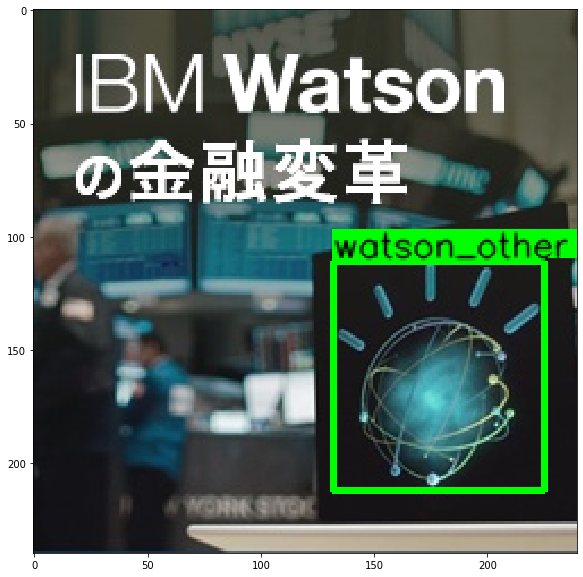

In [9]:
image, target = dataset[0]
image = image.mul(255).permute(1, 2, 0).byte().numpy()
labels = target['labels'].cpu().numpy()
boxes = target['boxes'].cpu().numpy()

for i,box in enumerate(boxes):
    txt = classes[labels[i]]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
    c = colors[labels[i]]
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), c , 2)
    cv2.rectangle(image,(box[0], box[1] - cat_size[1] - 2),(box[0] + cat_size[0], box[1] - 2), c, -1)
    cv2.putText(image, txt, (box[0], box[1] - 2), font, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(image)

## 3. モデルの作成

### ２通りの方法でモデルの作成を実施
- A. COCOデータセットで学習済みの物体検出モデル（Faster R-CNN ResNet-50 FPN）を追加学習
- B. Classificationモデル（MobileNet v2）をFaster R-CNNのバックボーンに使用

以降ではAあるいはBのどちらかを実行

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## A. COCOデータセットで学習済みの物体検出モデル（Faster R-CNN ResNet-50 FPN）を追加学習

In [11]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = len(classes)  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/wsuser/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 44.2MB/s] 


## B. Classificationモデル（MobileNet v2）をFaster R-CNNのバックボーンに使用 

In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=len(classes),
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

## 4. 学習

In [12]:
from engine import train_one_epoch, evaluate
import utils

In [13]:
# use our dataset and defined transformations
dataset = WatsonLogosDataset('images/', 'annotations/', classes, get_transform(True))
dataset_test = WatsonLogosDataset('images/', 'annotations/', classes, get_transform(False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
num_test = int(len(indices) * 0.2)
dataset = torch.utils.data.Subset(dataset, indices[:-num_test])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-num_test:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

In [15]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/26]  eta: 0:00:53  lr: 0.000205  loss: 1.2025 (1.2025)  loss_classifier: 1.0920 (1.0920)  loss_box_reg: 0.1009 (0.1009)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0079 (0.0079)  time: 2.0404  data: 0.0243  max mem: 2504
Epoch: [0]  [10/26]  eta: 0:00:25  lr: 0.002203  loss: 0.3755 (0.6196)  loss_classifier: 0.2658 (0.5124)  loss_box_reg: 0.0930 (0.0894)  loss_objectness: 0.0039 (0.0094)  loss_rpn_box_reg: 0.0084 (0.0084)  time: 1.5724  data: 0.0164  max mem: 2846
Epoch: [0]  [20/26]  eta: 0:00:09  lr: 0.004201  loss: 0.3746 (0.4923)  loss_classifier: 0.2286 (0.3734)  loss_box_reg: 0.0956 (0.1007)  loss_objectness: 0.0089 (0.0102)  loss_rpn_box_reg: 0.0084 (0.0080)  time: 1.5200  data: 0.0194  max mem: 2865
Epoch: [0]  [25/26]  eta: 0:00:01  lr: 0.005000  loss: 0.2869 (0.4508)  loss_classifier: 0.1579 (0.3262)  loss_box_reg: 0.0918 (0.1016)  loss_objectness: 0.0105 (0.0119)  loss_rpn_box_reg: 0.0085 (0.0112)  time: 1.5327  data: 0.0192  max mem: 2865
Epoch: [

## 5. テスト

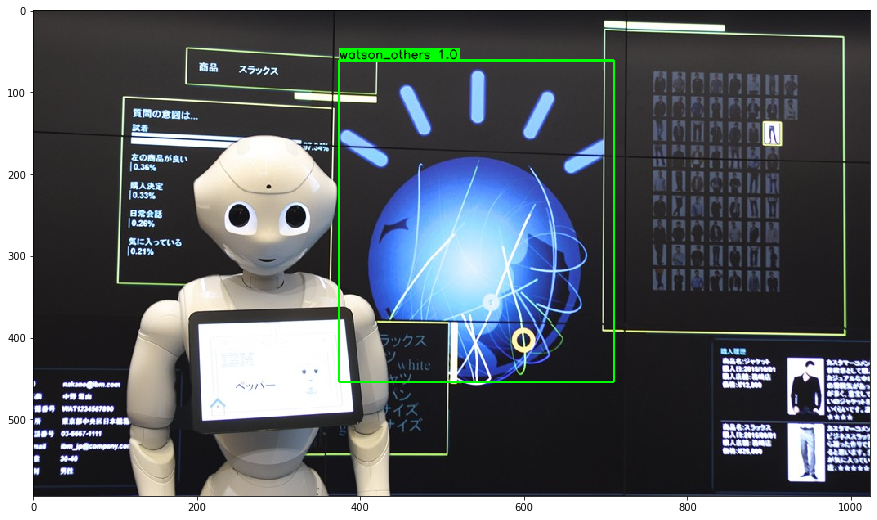

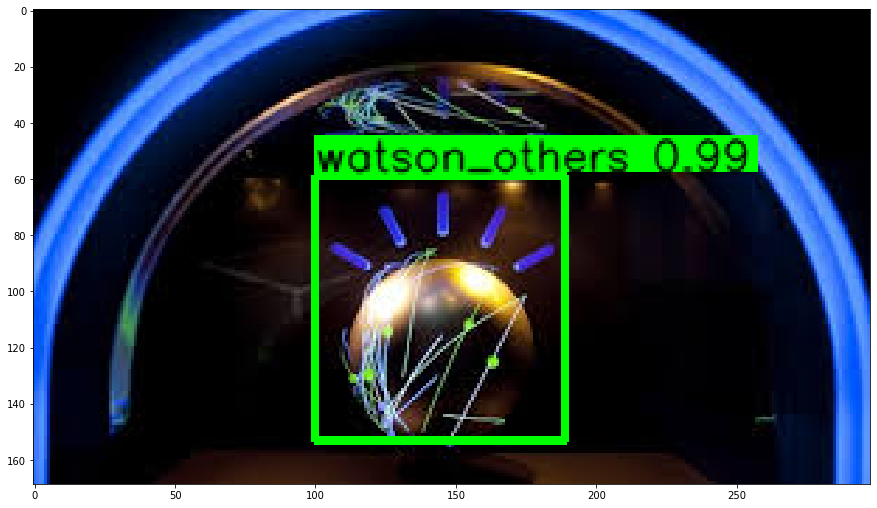

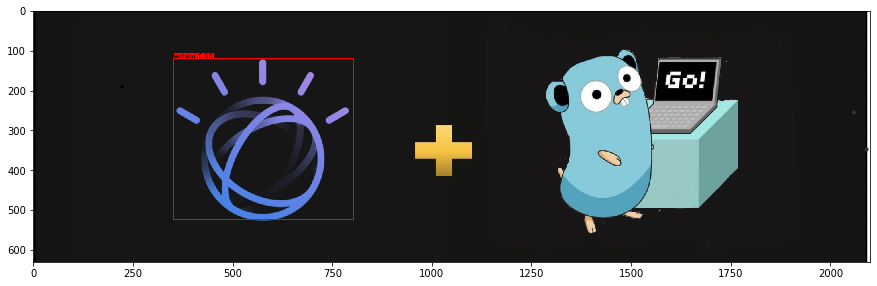

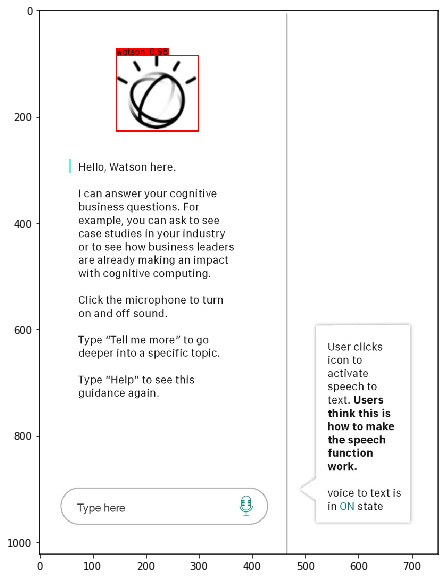

In [16]:
model.eval()
for imgfile in sorted(glob.glob('test/*')):
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_tensor = torchvision.transforms.functional.to_tensor(img)

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])
    
    for i,box in enumerate(prediction[0]['boxes']):
        score = prediction[0]['scores'][i].cpu().numpy()
        if score > 0.9:
            score = round(float(score),2)
            cat = prediction[0]['labels'][i].cpu().numpy()
            txt = '{} {}'.format(classes[int(cat)], str(score))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
            c = colors[int(cat)]
            box=box.cpu().numpy().astype('int')
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), c , 2)
            cv2.rectangle(img,(box[0], box[1] - cat_size[1] - 2),(box[0] + cat_size[0], box[1] - 2), c, -1)
            cv2.putText(img, txt, (box[0], box[1] - 2), font, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.show()